<a href="https://colab.research.google.com/github/Weff24/PrivacyPlate/blob/main/pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Data Extraction from XML Files

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import xml.etree.ElementTree as ET
import os
import sys
from collections import defaultdict

from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import matplotlib.patches as patches

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. Test XML Data Extraction: License Plate Crop Borders

In [2]:
# Path to annotation folder
annot_dir_path = Path("/content/drive/MyDrive/01-License Plates/annotations")

if not annot_dir_path.exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# Extract the box from xml files
box_locations = defaultdict(list)
box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location

for path in os.listdir(annot_dir_path):
    tree = ET.parse(f'{annot_dir_path}/{path}')  # Replace 'your_xml_file.xml' with your XML file path
    root = tree.getroot()

    # Get key from XML
    xml_ind =int(path[4:-4])

    for element in box_elements:
      box_locations[xml_ind].append(int(root.find('object').find('bndbox').find(element).text))

# 2. Test License Plate Image Data Import

In [ ]:
img_dir_path = Path("/content/drive/MyDrive/01-License Plates/images")

if not img_dir_path.exists():
  print("Image directory path does not exist")
  sys.exit(1)

images = []

i = 0
for i, path in enumerate(os.listdir(img_dir_path)):
  image = mpimg.imread(f"{img_dir_path}/{path}")
  fig, ax = plt.subplots()

  ax.imshow(image)

  # Red box around to see the license plate
  box = box_locations[int(path[4:-4])]
  rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)

  plt.show()


  i += 1
  if i > 5:
    break

# 3. CNN Construction

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [23]:
class CarDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        # Initialize your dataset here
        self.img_dir_path = data_dir + "/images"
        self.annot_dir_path = data_dir + "/annotations"
        self.transform = transform
        self.image_and_box = [set() for i in range(len(os.listdir(f"{self.img_dir_path}")))]
        self.box_elements = ['xmin', 'ymin', "xmax", "ymax"] # order of the box location

        # populate image paths
        for path in os.listdir(self.img_dir_path):
          # Get box location info here
          tree = ET.parse(f'{self.annot_dir_path}/{path[:-4]}.xml')  # Replace 'your_xml_file.xml' with your XML file path
          root = tree.getroot()

          # Get key from XML
          xml_ind = int(path[4:-4])
          box_location = []
          for element in self.box_elements:
            box_location.append(int(root.find('object').find('bndbox').find(element).text))

          # Add to image paths
          xml_ind = int(path[4:-4])
          self.image_and_box[xml_ind] = (f"{self.img_dir_path}/{path}", box_location)

    def __len__(self):
        # Return the number of samples in your dataset
        return len(self.image_and_box)

    def __getitem__(self, index):
        # Load and preprocess the data at the specified index
        image_path, label = self.image_and_box[index]

        # Show data for now
        image = mpimg.imread(image_path)
        fig, ax = plt.subplots()

        ax.imshow(image)

        # Red box around to see the license plate
        print("Label: ", label)
        rect = patches.Rectangle((label[0], label[1]), label[2] - label[0], label[3] - label[1], linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

        plt.show()

Label:  [229, 176, 270, 193]


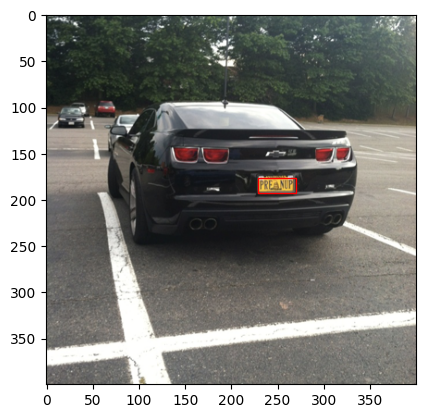

In [26]:
data_dir = "/content/drive/MyDrive/01-License Plates"

if not Path(data_dir).exists():
  print("Annotation directory path does not exist")
  sys.exit(1)

# TODO: Add resizing without changign aspect ratio
transform = transforms.Compose([transforms.Resize((224, 224))]) # fill in gray area to 512 x 512

license_plates_dataset = CarDataset(data_dir)
license_plates_dataset[2]
